In [2]:
import datetime
import math
import pathlib
import re

import tqdm

import rosbag
import geometry_msgs.msg as geomsg
import message_filters

import cameratransform as ct
from tf.transformations import quaternion_from_euler, euler_from_quaternion
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import numpy as np
import cv2

from sklearn.decomposition import PCA

from cv_bridge import CvBridge

import torch
import torchvision
import av
import postprocess

In [76]:
!ls ../data

In [3]:
#bag = rosbag.Bag("../data/dvs_2021-09-07-10-40-48.bag")
bag = rosbag.Bag("../record.bag")
#model_topic = "/gazebo/model_states"
model_topic = "/gazebo_modelstates_with_timestamp"
camera_topic = "/robot/camera_rgb_00"
event_topic = "/robot/camera_dvs_00/events"
bridge = CvBridge()
g = postprocess.process_bag(bag, bridge, model_topic, camera_topic, event_topic, model_path="../Models")

In [ ]:
camera_poses = postprocess.camera_pose_generator(bag, model_topic)
images = postprocess.image_generator(bag, bridge, camera_topic)
events = postprocess.event_generator(bag, event_topic)

In [4]:
tuples = []
try:
    for t in tqdm.tqdm(g):
        tuples.append(t)
except Exception as e:
    print(e)

998it [05:10,  3.21it/s]

generator raised StopIteration


In [18]:
tuples[0][3]

[array([235.17493216, 334.04911975,   1.82020132,   0.        ,
          0.        ,   0.        ]),
 array([300.24251012, 322.41873386,   1.91261508,   0.        ,
          0.        ,   0.        ]),
 array([261.2471196 , 343.77216217,   1.74949734,   0.        ,
          0.        ,   0.        ])]

/usr/local/lib/python3.8/dist-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


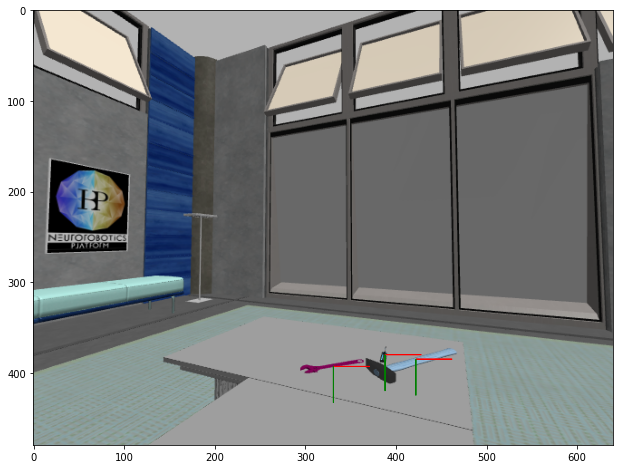

In [19]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(12, 8))

def draw_img(data):
    def draw_frame(index):
        plt.cla()
        img = data[index][0]
        poses = data[index][3]
        im = plt.imshow(img, animated=True)
        for tool in poses:
            x, y, z = torch.tensor(tool[:3], dtype=torch.int64)
            if x < 40 or x >= 600 or y < 40 or y >= 440:
                continue
            a, b, c = torch.tensor(tool[3:6])
            r = Rotation.from_euler("xyz", [a,b,c])
            rotated = r.apply([40, 0, 0])
            plt.arrow(x, y, *rotated[:2], color="red")
            rotated = r.apply([0, 40, 0])
            plt.arrow(x, y, *rotated[:2], color="green")
            rotated = r.apply([0, 0, 40])
            plt.arrow(x, y, *rotated[:2], color="white")
    return draw_frame

ani = animation.FuncAnimation(fig, draw_img(tuples), frames=len(tuples), interval=20)
HTML(ani.to_html5_video())

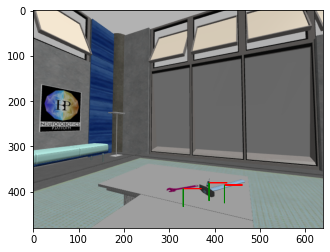

In [20]:
ani.save('labels.mp4')

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(12, 8))

def draw_img(data):
    def draw_frame(index):
        plt.cla()
        img = np.concatenate([data[index][1], np.zeros((480, 640, 1))], axis=2)
        poses = data[index][3]
        im = plt.imshow(img, animated=True)
        for tool in poses:
            x, y, z = torch.tensor(tool[:3], dtype=torch.int64)
            if x < 20 or x >= 620 or y < 20 or y >= 460:
                continue
            a, b, c = torch.tensor(tool[3:])
            r = Rotation.from_euler("xyz", [a,b,c])
            rotated = r.apply([20, 0, 0])
            plt.arrow(x, y, *rotated[:2], color="red")
            rotated = r.apply([0, 20, 0])
            plt.arrow(x, y, *rotated[:2], color="green")
            rotated = r.apply([0, 0, 20])
            plt.arrow(x, y, *rotated[:2], color="white")
    return draw_frame

ani = animation.FuncAnimation(fig, draw_img(tuples), frames=200, interval=20)
HTML(ani.to_html5_video())

In [ ]:
d = []
for t in tuples:
    d.append(np.stack(t[3])[:,2])

np.histogram(np.stack(d))

In [ ]:
from scipy.ndimage import gaussian_filter

img = np.zeros((480, 640))
img[50:430,50:590] = 1
img = gaussian_filter(img, sigma=30)
plt.imshow(img)

In [ ]:
r = Rotation.from_euler("xyz", [a,b,c])

In [ ]:
r.apply([10, 10, 10])

In [ ]:
hammer = postprocess.get_tool_poses(bag, model_topic)['hammer_simple']

In [ ]:
dae_models = pathlib.Path("../Models").glob("*/*.dae")
meshes = {key.stem: postprocess.get_mesh(key) for key in dae_models}

In [ ]:
hammer_mesh = meshes['hammer_simple']

In [ ]:
p = postprocess.transform_tool(hammer_mesh[0], hammer).mean(0)

In [ ]:
orientation = hammer.orientation
orientation_quat = np.array(
    [orientation.x, orientation.y, orientation.z, orientation.w]
)
rotation = Rotation.from_quat(orientation_quat)
r = rotation.as_rotvec()

In [ ]:
hammer_pose = np.append(p, r)

In [ ]:
camera.getPos()

In [ ]:
x, y = camera.imageFromSpace(hammer_pose[:3])

In [ ]:
y

In [ ]:
np.linalg.norm(hammer_pose[:3] - camera.getPos())

In [ ]:
postprocess.transform_tool(hammer_mesh[0], np.append(np.mean(out, axis=0), hammer_pose[:3]))

In [ ]:
hammer_pca = PCA(n_components=2)
out = hammer_pca.fit_transform(hammer_mesh[0])
np.mean(out, axis=0)

In [ ]:
np.mean(hammer_mesh[0], axis=0)

In [ ]:
hammer_pca.inverse_transform(np.mean(out, axis=0))

In [ ]:
camera_poses = postprocess.camera_pose_generator(bag, model_topic)

In [ ]:
pose = next(camera_poses)
pose

In [ ]:
r = Rotation.from_euler("xyz", pose[1][3:])

In [ ]:
r.inv().

In [ ]:
r.apply([0, 0, 1])

In [ ]:
pose[1]

In [ ]:
camera = postprocess.transform_camera(pose[1], 0.5003983220157445 * 640, [640, 480])

camera.getPos()

In [ ]:
q = np.array([hammer.orientation.x, hammer.orientation.y, hammer.orientation.z, hammer.orientation.w])
qr = Rotation.from_quat(q)
qr

In [ ]:
o = pose[1][3:] - qr.as_euler('xyz')

In [ ]:
np.array([1, 2, 3, *o])

In [ ]:
hammer.orientation.

In [ ]:
hammer

In [ ]:
ga = postprocess.align_generators(camera_poses, images, events)

In [ ]:
for x in ga:
    print(list(x))
    break

In [4]:
def transform_tool(mesh, pose):
    orientation = pose.orientation
    orientation_quat = np.array(
        [orientation.x, orientation.y, orientation.z, orientation.w]
    )
    rotation = Rotation.from_quat(orientation_quat)
    position = np.array([pose.position.x, pose.position.y, pose.position.z])
    return position + rotation.apply(mesh), rotation


In [5]:
def image_labels(camera, tool_poses, tool_meshes, resolution):
    image_class = np.zeros(list(reversed(resolution)))
    tool_pose_labels = []
    for tool_class, (tool, pose) in enumerate(tool_poses.items()):
        raw_vertices, raw_triangles = tool_meshes[tool]
        
        # Fill in segmentation polygons
        transformed_vertices, tool_orientation = transform_tool(raw_vertices, pose)
        projection = camera.imageFromSpace(transformed_vertices)
        triangles = np.take(projection, raw_triangles, axis=0).astype(int)
        for mesh in triangles:
            # Tool class is incremented such that 0 becomes "background"
            cv2.fillConvexPoly(image_class, mesh, tool_class + 1)
            
        pca = PCA(n_components=3)
        transformed_coords = pca.fit_transform(transformed_vertices)
        min_coords = transformed_coords.min(axis=0)
        max_coords = transformed_coords.max(axis=0)
        center_coords = (min_coords + max_coords) * 0.5
        pca_center = pca.inverse_transform(center_coords)
        x, y = camera.imageFromSpace(pca_center)
        depth = np.linalg.norm(pca_center - camera.getPos())
        tool_pose_labels.append(np.array([x, y, depth, 0, 0, 0]))
    return image_class, tool_pose_labels

In [6]:
def camera_pose_generator(bag, model_topic):
    camera_offset = [0, 0, 1]
    for topic, gazebo_msg, t in bag.read_messages(topics=[model_topic]):
        msg = gazebo_msg.gazebo_model_states
        camera_pose = msg.pose[0]
        orientation = camera_pose.orientation
        quaternion = np.array(
            [orientation.x, orientation.y, orientation.z, orientation.w]
        )
        euler = euler_from_quaternion(quaternion)
        list_pose = [
            camera_pose.position.x + camera_offset[0],
            camera_pose.position.y + camera_offset[1],
            camera_pose.position.z + camera_offset[2],
        ]
        list_pose.extend(euler)
        yield (message_to_time(gazebo_msg), np.array(list_pose))

In [ ]:
image_old = image
cam_old = camera2

In [53]:
#bag = rosbag.Bag("../data/dvs_2021-09-07-10-40-48.bag")
bag = rosbag.Bag("../record.bag")
#model_topic = "/gazebo/model_states"
model_topic = "/gazebo_modelstates_with_timestamp"
camera_topic = "/robot/camera_rgb_00"
event_topic = "/robot/camera_dvs_00/events"
bridge = CvBridge()
g = postprocess.process_bag(bag, bridge, model_topic, camera_topic, event_topic, model_path="../Models")

In [73]:
#for x in range(5):
out = next(g)

In [ ]:
m = np.array(m)

In [ ]:
m @ np.array([1, 4, 0, 1])

In [ ]:
np.nan_to_num(m, 0)

In [ ]:
x = np.ones((10, 3))
y = np.ones((10, 1))
p = np.hstack([x, y])
t = m @ p.T
t[0] / t[1]

In [ ]:
m = np.array(
    [[320.25492609007654, 0.0,                320.5, -22.41784482630536],
     [0.0,                320.25492609007654, 240.5, 0.0],
     [0.0,                0.0,                1.0,   0.0]]
)
f_x = m[0][0]
f_y = m[1][1] 
c_x = m[0][2]
c_y = m[1][2]

In [ ]:
cam_v = m @ np.array([pos.x, pos.y, pos.z, 1])
cam = np.array([cam_v[0] / cam_v[2], cam_v])

position: 
  x: -1.2368058808689864
  y: 1.4341877850275042
  z: 1.5896951552135623
orientation: 
  x: -0.05322470118666965
  y: -0.09968890339160769
  z: 0.4057673502461496
  w: -0.9069631256001464
0.9197898430989798 12.94537555151012 -48.10229212157546
(datetime.time(0, 0, 0, 16000), datetime.time(0, 0, 0, 16000), datetime.time(0, 0, 0, 16000))
(480, 640)


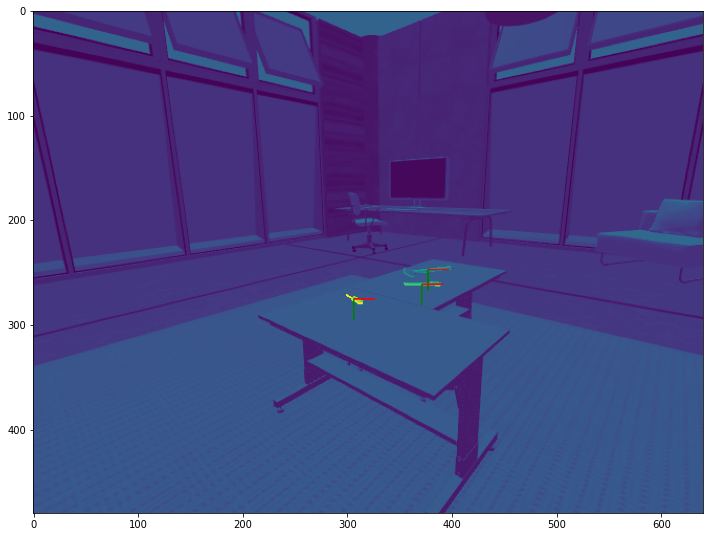

In [74]:
plt.figure(figsize=(12, 10))
(image, camera, camera_pose, tool_poses, tool_meshes, labels, event, tool_labels, times) = out
pos = camera_pose.position
(x, y, z) = pos.x, pos.y, pos.z
ori = camera_pose.orientation
rotation = Rotation.from_quat([ori.x, ori.y, ori.z, ori.w])
(roll, pitch, yaw) = rotation.as_euler("xyz", degrees=True)
projection = ct.RectilinearProjection(
    #focallength_x_px = 420,
    #focallength_y_px = 330,
    focallength_px=320.2549261, # Focallength from 1.57r field of view
    #view_x_deg=1.57 * 180 / np.pi,
    center=(320.5, 240.5),
)
# projection = ct.RectilinearProjection(
#     focallength_x_px=f_x,
#     focallength_y_px=f_y,
#     center_x_px=c_x,
#     center_y_px=c_y
# )
print(camera_pose)
print(roll, pitch, yaw)
orientation = ct.SpatialOrientation(
   pos_x_m=x, pos_y_m=y, elevation_m=z,
   roll_deg=-roll, tilt_deg=90-pitch, heading_deg=90-yaw
)
camera2 = ct.Camera(projection, orientation)
label, tool_labels = image_labels(camera2, tool_poses, tool_meshes, (640, 480))
print(times)
print(label.shape)
#plt.imshow(image)
for tool in tool_labels:
    x, y, z = torch.tensor(tool[:3], dtype=torch.int64)
    if x < 20 or x >= 620 or y < 20 or y >= 460:
        continue
    a, b, c = torch.tensor(tool[3:])
    r = Rotation.from_euler("xyz", [a,b,c])
    rotated = r.apply([20, 0, 0])
    plt.arrow(x, y, *rotated[:2], color="red")
    rotated = r.apply([0, 20, 0])
    plt.arrow(x, y, *rotated[:2], color="green")
    rotated = r.apply([0, 0, 20])
    plt.arrow(x, y, *rotated[:2], color="white")
plt.imshow(image.sum(-1) / 400 + label)
#plt.imshow(event.sum(-1)  + label)

In [ ]:
plt.figure(figsize=(16, 8))
(image, events, labels, poses, probablilities) = out
#images = image_labels(camera, tool_poses, tool_meshes)
#cl = images[0] + images[1] + images[2]
#cl = np.broadcast_to(np.expand_dims(cl, 2), (512, 512, 3))
plt.imshow(events.sum(-1) + labels / 4)
#plt.imshow(labels)
plt.show()

In [ ]:
plt.imshow(images[4])x

In [ ]:
rr =np.array([0, 0.78, 0.78]) - r.as_euler('xyz')
Rotation.from_euler('xyz', rr)

In [ ]:
for image, camera_pose, tool_poses, tool_meshes, times in g:
    (x, y, z, roll, pitch, yaw) = camera_pose
    (roll, pitch, yaw) = (radians * 180 / np.pi for radians in (roll, pitch, yaw))
    projection = ct.RectilinearProjection(
        focallength_px=0.5003983220157445 * 512, image=(512, 512)
    )
    orientation = ct.SpatialOrientation(
        pos_x_m=x + 0.04, pos_y_m=y - 0.08, elevation_m=z + 1.0,
        roll_deg=roll+11, tilt_deg=90-pitch, heading_deg=90-yaw,
    )
    camera = ct.Camera(projection, orientation)
    print(x, y, z, roll, pitch, yaw, camera_pose[3:])

    images = image_labels(camera, tool_poses, tool_meshes)
    cl = images[0] + images[1] + images[2]
    cl = np.broadcast_to(np.expand_dims(cl, 2), (512, 512, 3))
    plt.imshow(image / 300 + cl)
    plt.show()
    cl.min(), cl.max(), cl.mean(), times

In [ ]:
import torch
images = []
events = []
labels = []
for rgb, camera, camera_pose, poses, meshes, label, event, (tc, ti, te) in tqdm.tqdm(g):
    images.append(torch.tensor(rgb))
    events.append(torch.tensor(event))
    labels.append(torch.tensor(label))

In [ ]:
import torch
images = []
events = []
labels = []
for rgb, event, label in tqdm.tqdm(g):
    images.append(torch.tensor(rgb))
    events.append(torch.tensor(event))
    labels.append(torch.tensor(label))

In [ ]:
len(images)

In [ ]:
plt.imshow(events[100])

In [ ]:
torch_images = torch.stack([torch.tensor(x) for x in images])
torch_events = torch.stack([torch.tensor(x) for x in events])
torch_labels = torch.stack([torch.tensor(x) for x in labels])

In [ ]:
torchvision.io.write_video("e.mp4", torch_events / 3 + torch_labels * 100, fps=20)

In [ ]:
!ls ../data

In [ ]:
!ls ../data

In [ ]:
from natsort import natsorted

dataset = "../data/datasetdvs_2021-06-16-19-23-07"
files = !ls $dataset
sorted_files = natsorted(files)
len(sorted_files)

In [ ]:
import tqdm
file_images = []
file_labels = []
for file in tqdm.tqdm(sorted_files):
    with np.load(f"{dataset}/{file}") as data:
        rgb = data['images'] / 300
        label = data['labels']
        file_images.append(rgb)
        file_labels.append(label)

In [ ]:
plt.imshow(file_labels[1])

In [ ]:
plt.imshow(images[2])

In [ ]:
labels[2].shape

In [ ]:
plt.imshow(labels)

In [ ]:
i = 2
plt.imshow(labels[i].sum(2))

In [ ]:
ims = torch.stack([torch.tensor(x) for x in images])

In [ ]:
torchvision.io.write_video("h.mp4", ims, fps=20)